In [2]:
from datasets import load_dataset
import os

#full dataset (600GB of data)
dataset = load_dataset("HuggingFaceFV/finevideo", split="train", num_proc=64)

Resolving data files:   0%|          | 0/1357 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1357 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/906 [00:00<?, ?it/s]

In [3]:
dataset[0]['json']

{'content_fine_category': 'Engineering Projects',
 'content_metadata': {'characterList': [{'characterId': '1',
    'description': 'A young woman with long blonde hair, wearing a grey shirt and an orange safety vest. She is a participant in the heavy equipment operators course.',
    'name': 'Sara Paynton'},
   {'characterId': '2',
    'description': 'A man with a beard and glasses, wearing an orange polo shirt. He works at WorkBC as a Quality Assurance Training Coordinator.',
    'name': 'Paulo Fulgencio'},
   {'characterId': '3',
    'description': 'A man with short brown hair, wearing a light blue shirt. He is the COO of the Southern Interior Construction Association.',
    'name': 'Bill Everitt'},
   {'characterId': '4',
    'description': 'A man with short grey hair and glasses, wearing a black jacket. He is a Civil Manager at Construction Services Southern Interior.',
    'name': 'Charlie Kopola'},
   {'characterId': '5',
    'description': 'A man with long black hair, wearing a b

In [4]:
# Define the category you want to filter by
desired_category = 'Sports'  # Replace with your desired category

def is_desired_category(sample):
    return sample['json']['content_parent_category'] == desired_category

filtered_dataset = dataset.filter(is_desired_category, num_proc=32)

In [5]:
filtered_dataset

Dataset({
    features: ['mp4', 'json'],
    num_rows: 3359
})

In [43]:
import random 
from tqdm import tqdm

def convert_to_seconds(timestamp_str):
        h, m, s = map(float, timestamp_str.split(':'))
        return int(h*3600 + m*60 + s)

filtered_list = []
save_dir = "/home/ubuntu/temp"
os.makedirs(save_dir, exist_ok=True)
mp4_path = os.path.join(save_dir, "mp4s")
os.makedirs(mp4_path, exist_ok=True)

num_chunks = 4
chunk_seconds = 5
for i, sample in tqdm(enumerate(filtered_dataset), total=len(filtered_dataset)):
    mp4_video_path = f"{mp4_path}/{i}.mp4"

    chunks = []
    all_activities = []
    for activity in sample['json']['content_metadata']['scenes']:
        all_activities += activity['activities']
    timestamps_start = []
    timestamps_end = []
    for act in all_activities:
        # convert from string to seconds '00:02:01.000' -> 121
        try:
            timestamp_start = convert_to_seconds(act['timestamp']['start_timestamp'])
        except:
            timestamp_start = 0
        try:
            timestamp_end = convert_to_seconds(act['timestamp']['end_timestamp'])
        except:
            timestamp_end = timestamp_start + 5
        timestamps_start.append(timestamp_start)
        timestamps_end.append(timestamp_end)

    # 0. Filter out if few activities
    # print(len(timestamps_start), num_chunks, timestamps_start[num_chunks-1], chunk_seconds*num_chunks)
    if(len(timestamps_start) < num_chunks):
        continue
    else:
        if(timestamps_start[num_chunks-1] > chunk_seconds*num_chunks):
            continue
    # filter out if duration is less than num_chunks*chunk_seconds
    if(timestamps_start[-1] - timestamps_start[0] < num_chunks*chunk_seconds):
        continue
    # 1. Create Chunks
    curr_visible_activities = []
    activity_idx = 0
    for j in range(num_chunks):
        chunk = {
            'interval': (j*chunk_seconds, (j+1)*chunk_seconds),
        }
        for idx, act in enumerate(all_activities):
            if(idx >= activity_idx):
                if(timestamps_start[idx] < (j+1)*chunk_seconds):
                    curr_visible_activities.append(all_activities[activity_idx])
                    activity_idx += 1
        #random sample from visible activities
        if(len(curr_visible_activities) == 0):
            chunk['activity'] = {"start": timestamps_start[0], 
                                 "end": timestamps_end[0], 
                                 "description": all_activities[0]['description']}
        else:
            random_idx = random.randint(0, len(curr_visible_activities)-1)
            chunk['activity'] = {"start": timestamps_start[random_idx],
                                 "end": timestamps_end[random_idx], 
                                 "description": curr_visible_activities[random_idx]['description']}
        chunks.append(chunk)


    # C. Video mp4 save
    with open(f"{mp4_video_path}", "wb") as f:
        f.write(sample['mp4'])
    
    filtered_list.append({"chunks": chunks, "mp4_path": mp4_video_path})

100%|██████████| 3359/3359 [00:13<00:00, 246.82it/s]


In [45]:
len(filtered_list)
# save to huggingface dataset
from datasets import Dataset
filtered_dataset = Dataset.from_list(filtered_list)
filtered_dataset.save_to_disk(f"/home/ubuntu/temp/{desired_category}_dataset")

Saving the dataset (0/1 shards):   0%|          | 0/579 [00:00<?, ? examples/s]

In [46]:
filtered_dataset[0]

{'chunks': [{'activity': {'description': 'Police recruits work together on laptops',
    'end': 4,
    'start': 3},
   'interval': [0, 5]},
  {'activity': {'description': 'Police recruit #2 runs', 'end': 8, 'start': 7},
   'interval': [5, 10]},
  {'activity': {'description': 'Police recruits practice combat',
    'end': 1,
    'start': 0},
   'interval': [10, 15]},
  {'activity': {'description': 'Police officers walk together on a sidewalk',
    'end': 3,
    'start': 2},
   'interval': [15, 20]}],
 'mp4_path': '/home/ubuntu/temp/mp4s/0.mp4'}

In [31]:
filtered_dataset[0]['json']['content_metadata']['scenes'][0]['activities']

[{'description': 'Police recruits practice combat',
  'timestamp': {'end_timestamp': '00:00:01.000',
   'start_timestamp': '00:00:00.000'}},
 {'description': 'Police officers walk together on a sidewalk',
  'timestamp': {'end_timestamp': '00:00:03.000',
   'start_timestamp': '00:00:02.000'}},
 {'description': 'Police recruits work together on laptops',
  'timestamp': {'end_timestamp': '00:00:04.000',
   'start_timestamp': '00:00:03.000'}},
 {'description': 'Police officers stand in formation',
  'timestamp': {'end_timestamp': '00:00:08.000',
   'start_timestamp': '00:00:06.000'}},
 {'description': 'Police recruit #2 runs',
  'timestamp': {'end_timestamp': '00:00:08.000',
   'start_timestamp': '00:00:07.000'}},
 {'description': 'Police recruits practice shooting',
  'timestamp': {'end_timestamp': '00:00:10.000',
   'start_timestamp': '00:00:09.000'}},
 {'description': 'Police officers ride in a patrol car',
  'timestamp': {'end_timestamp': '00:00:11.000',
   'start_timestamp': '00:00:10

In [37]:
chunks

[{'interval': (0, 5),
  'mp4_path': '/home/ubuntu/temp/mp4s/0.mp4',
  'activity': {'start': 0,
   'end': 1,
   'activity': 'Police recruits practice combat'}},
 {'interval': (5, 10),
  'mp4_path': '/home/ubuntu/temp/mp4s/0.mp4',
  'activity': {'start': 6,
   'end': 8,
   'activity': 'Police officers stand in formation'}},
 {'interval': (10, 15),
  'mp4_path': '/home/ubuntu/temp/mp4s/0.mp4',
  'activity': {'start': 9,
   'end': 10,
   'activity': 'Police recruits practice shooting'}},
 {'interval': (15, 20),
  'mp4_path': '/home/ubuntu/temp/mp4s/0.mp4',
  'activity': {'start': 7, 'end': 8, 'activity': 'Police recruit #2 runs'}}]

In [26]:
timestamps_start

[5, 41, 71, 86, 126, 150, 192]

In [24]:
chunks

[{'interval': (0, 5),
  'mp4_path': '/home/ubuntu/temp/mp4s/1.mp4',
  'activity': {'start': 5,
   'end': 40,
   'activity': 'Kerry talks about her role as a trainer assessor.'}},
 {'interval': (5, 10),
  'mp4_path': '/home/ubuntu/temp/mp4s/1.mp4',
  'activity': {'start': 5,
   'end': 40,
   'activity': 'Kerry talks about her role as a trainer assessor.'}},
 {'interval': (10, 15),
  'mp4_path': '/home/ubuntu/temp/mp4s/1.mp4',
  'activity': {'start': 5,
   'end': 40,
   'activity': 'Kerry talks about her role as a trainer assessor.'}},
 {'interval': (15, 20),
  'mp4_path': '/home/ubuntu/temp/mp4s/1.mp4',
  'activity': {'start': 5,
   'end': 40,
   'activity': 'Kerry talks about her role as a trainer assessor.'}}]

In [13]:
filtered_dataset[0]['json'].keys()

dict_keys(['content_fine_category', 'content_metadata', 'content_parent_category', 'duration_seconds', 'original_json_filename', 'original_video_filename', 'resolution', 'text_to_speech', 'text_to_speech_word_count', 'timecoded_text_to_speech', 'youtube_age_limit', 'youtube_categories', 'youtube_channel', 'youtube_channel_follower_count', 'youtube_comment_count', 'youtube_description', 'youtube_like_count', 'youtube_tags', 'youtube_title', 'youtube_upload_date', 'youtube_view_count'])

In [14]:
all_activities

[{'description': 'Police recruits practice combat',
  'timestamp': {'end_timestamp': '00:00:01.000',
   'start_timestamp': '00:00:00.000'}},
 {'description': 'Police officers walk together on a sidewalk',
  'timestamp': {'end_timestamp': '00:00:03.000',
   'start_timestamp': '00:00:02.000'}},
 {'description': 'Police recruits work together on laptops',
  'timestamp': {'end_timestamp': '00:00:04.000',
   'start_timestamp': '00:00:03.000'}},
 {'description': 'Police officers stand in formation',
  'timestamp': {'end_timestamp': '00:00:08.000',
   'start_timestamp': '00:00:06.000'}},
 {'description': 'Police recruit #2 runs',
  'timestamp': {'end_timestamp': '00:00:08.000',
   'start_timestamp': '00:00:07.000'}},
 {'description': 'Police recruits practice shooting',
  'timestamp': {'end_timestamp': '00:00:10.000',
   'start_timestamp': '00:00:09.000'}},
 {'description': 'Police officers ride in a patrol car',
  'timestamp': {'end_timestamp': '00:00:11.000',
   'start_timestamp': '00:00:10

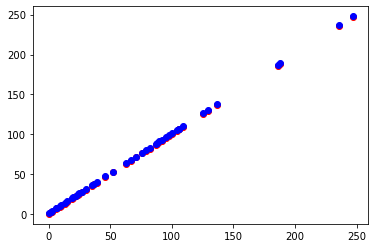

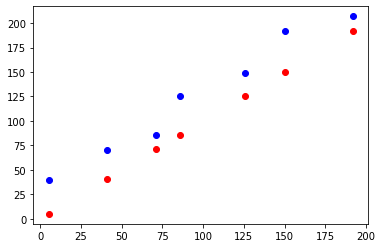

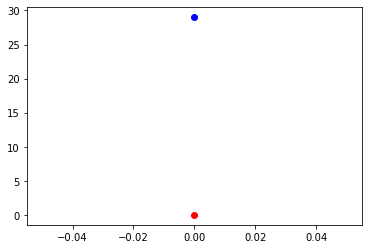

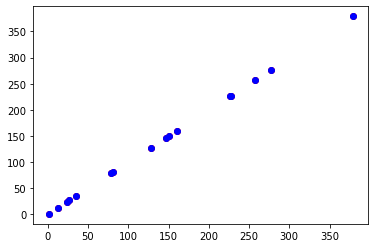

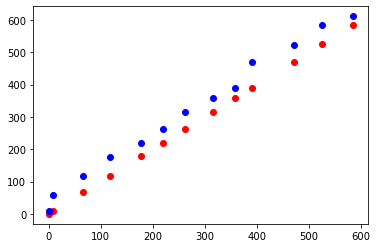

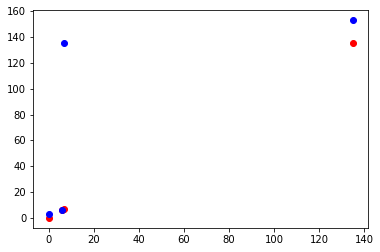

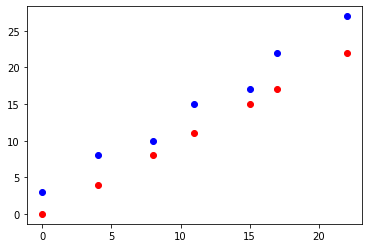

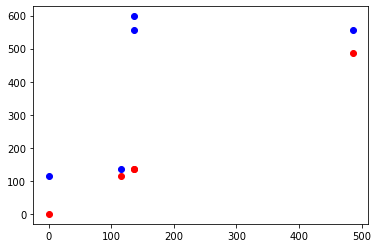

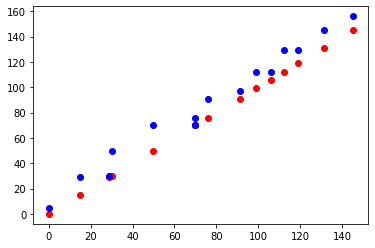

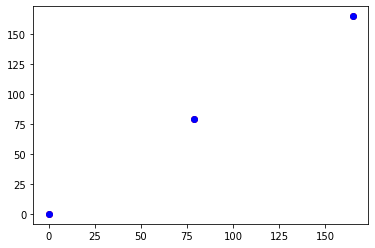

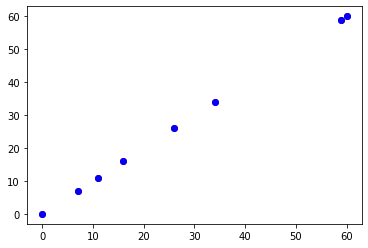

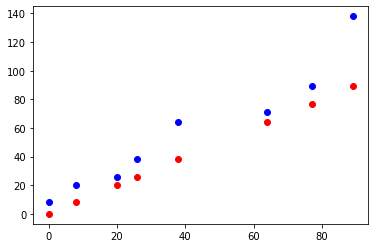

In [20]:
for i, sample in enumerate(filtered_dataset):
    with open(f"{mp4_path}/{i}.mp4", "wb") as f:
        f.write(sample['mp4'])

    chunks = {}
    all_activities = []
    for activity in sample['json']['content_metadata']['scenes']:
        all_activities += activity['activities']

    acts = all_activities
    timestamps_start = []
    timestamps_end = []
    def convert_to_seconds(timestamp_str):
        h, m, s = map(float, timestamp_str.split(':'))
        return int(h*3600 + m*60 + s)
    for act in acts:
        # convert from string to seconds '00:02:01.000' -> 121
        timestamp_start = convert_to_seconds(act['timestamp']['start_timestamp'])
        timestamp_end = convert_to_seconds(act['timestamp']['end_timestamp'])
        
        timestamps_start.append(timestamp_start)
        timestamps_end.append(timestamp_end)

    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(timestamps_start, timestamps_start, 'ro')
    plt.plot(timestamps_start, timestamps_end, 'bo')
    plt.show()

    if(i>10):
        break